# 02 — Embedding Exploration & MoA Prediction

**Goal (Task 2):** Use the provided embeddings to derive phenotype / MoA information.

**Workflow:**
1. **Visualize the 3 provided embeddings** (raw PCA, normalized PCA, brightfield)
2. **Assess confounders** in raw vs. normalized (source, concentration, viability)
3. **Multi-model ML prediction** of targets/pathways (LR, RF, XGBoost, Ensemble)
4. **Compare baseline vs. embeddings** with comprehensive metrics

The key insight: we have 3 pre-computed embeddings to work with. Let's understand what they capture *before* building predictive models.


## 0  Setup & load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter

from sklearn.decomposition import PCA
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

import xgboost
import umap

sns.set_style("whitegrid")
plt.rcParams.update({"figure.dpi": 100, "figure.figsize": (10, 6)})

DATA_PATH = Path("./phh_prod_image_data_oasis_with_dmso.parquet")
df = pd.read_parquet(DATA_PATH)
print(f"Loaded {len(df):,} wells")


Loaded 24,576 wells


## 1  Expand the 3 provided embeddings

In [2]:
def expand_embedding(series):
    """Convert a column of list/array objects into a 2D numpy array."""
    return np.stack(series.values).astype(np.float32)

# The dataset provides 3 embedding types
pca_raw  = expand_embedding(df["pca_embedding_raw"])          # (N, 128) - NOT batch-corrected
pca_norm = expand_embedding(df["pca_embedding_normalized"])   # (N, 128) - batch-corrected per source
brightfield = expand_embedding(df["brightfield"])             # (N, 768) - raw DINOv2 single channel

print("pca_embedding_raw        :", pca_raw.shape, " (PCA-reduced, NOT normalized)")
print("pca_embedding_normalized :", pca_norm.shape, "(PCA-reduced, DMSO-normalized per source)")
print("brightfield              :", brightfield.shape, "(raw DINOv2 from brightfield channel)")


pca_embedding_raw        : (24576, 256)  (PCA-reduced, NOT normalized)
pca_embedding_normalized : (24576, 256) (PCA-reduced, DMSO-normalized per source)
brightfield              : (24576, 768) (raw DINOv2 from brightfield channel)


## 2  Filter to bioactive wells & clean concentration

In [3]:
mask_bio = df["compound_id"] != "DMSO"
df_bio = df[mask_bio].reset_index(drop=True).copy()

pca_raw_bio  = pca_raw[mask_bio]
pca_norm_bio = pca_norm[mask_bio]
brightfield_bio = brightfield[mask_bio]

print(f"Bioactive wells: {len(df_bio):,}")
print(f"DMSO wells (excluded): {(~mask_bio).sum():,}")

# Round concentration for cleaner visualization
df_bio["compound_concentration_um"] = df_bio["compound_concentration_um"].round(2)
print(f"\nUnique concentrations: {sorted(df_bio['compound_concentration_um'].dropna().unique())}")


Bioactive wells: 20,160
DMSO wells (excluded): 4,416

Unique concentrations: [np.float32(0.01), np.float32(0.03), np.float32(0.05), np.float32(0.08), np.float32(0.14), np.float32(0.2), np.float32(0.41), np.float32(0.7), np.float32(1.0), np.float32(2.2), np.float32(3.5), np.float32(6.7), np.float32(11.0), np.float32(20.0), np.float32(33.5), np.float32(100.0)]


## 3  Visualize the provided embeddings in 2D

**Strategy:** The 128-dim PCA embeddings already capture the main variance. We'll:
1. Use the **first 2 PCs** directly for `pca_raw` and `pca_norm`
2. Run PCA on `brightfield` (768→2) for comparison
3. Optionally: compute UMAP/t-SNE for prettier nonlinear visualization

**Key question:** Does normalization remove batch effects while preserving biology?


In [4]:
# ── Extract 2D coordinates from each embedding ──

# For 128-dim embeddings: first 2 components are already the top PCs
raw_pc1, raw_pc2 = pca_raw_bio[:, 0], pca_raw_bio[:, 1]
norm_pc1, norm_pc2 = pca_norm_bio[:, 0], pca_norm_bio[:, 1]

# For brightfield (768-dim): run PCA to get top 2 components
pca_bright = PCA(n_components=2, random_state=42)
bright_2d = pca_bright.fit_transform(brightfield_bio)
bright_pc1, bright_pc2 = bright_2d[:, 0], bright_2d[:, 1]

# Store in df_bio
df_bio["raw_pc1"] = raw_pc1
df_bio["raw_pc2"] = raw_pc2
df_bio["norm_pc1"] = norm_pc1
df_bio["norm_pc2"] = norm_pc2
df_bio["bright_pc1"] = bright_pc1
df_bio["bright_pc2"] = bright_pc2

print("✓ 2D coordinates extracted")
print(f"  Brightfield variance explained by PC1+PC2: {pca_bright.explained_variance_ratio_[:2].sum():.1%}")


✓ 2D coordinates extracted
  Brightfield variance explained by PC1+PC2: 63.1%


## 4  Compare RAW vs NORMALIZED embeddings

**Goal:** Assess whether normalization removes confounders (source, concentration, viability).

We'll plot raw vs. normalized side-by-side, colored by:
- **Source** (batch) — should be mixed after normalization
- **Concentration** — dose-response structure
- **Viability (mtt)** — are dead cells clustering?
- **Cytotoxicity (ldh)** — same as viability but inverse


In [16]:
def compare_all_embeddings(col, title_suffix, cmap="viridis", s=3, alpha=0.5):
    """3-panel scatter: raw PCA vs normalized PCA vs brightfield, colored by metadata."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    vals = df_bio[col]
    
    is_categorical = (not pd.api.types.is_numeric_dtype(vals)) or (vals.nunique() <= 25)
    
    for ax, (pc1_col, pc2_col, title) in zip(
        axes,
        [("raw_pc1", "raw_pc2", "RAW\n(pca_embedding_raw)"),
         ("norm_pc1", "norm_pc2", "NORMALIZED\n(pca_embedding_normalized)"),
         ("bright_pc1", "bright_pc2", "BRIGHTFIELD\n(single channel)")]
    ):
        if is_categorical:
            unique_vals = vals.unique()
            palette = sns.color_palette(cmap, n_colors=min(len(unique_vals), 20))
            for i, val in enumerate(unique_vals[:20]):
                mask = vals == val
                ax.scatter(df_bio.loc[mask, pc1_col], df_bio.loc[mask, pc2_col],
                           s=s, alpha=alpha, label=str(val), color=palette[i % len(palette)])
            if len(unique_vals) <= 10:
                ax.legend(fontsize=7, markerscale=3, loc="best")
        else:
            sc = ax.scatter(df_bio[pc1_col], df_bio[pc2_col],
                            c=vals, cmap=cmap, s=s, alpha=alpha)
            plt.colorbar(sc, ax=ax, label=col, fraction=0.046)
        
        ax.set_xlabel("PC1", fontsize=9)
        ax.set_ylabel("PC2", fontsize=9)
        ax.set_title(title, fontsize=10)
        ax.grid(alpha=0.3)
    
    fig.suptitle(title_suffix, fontsize=12, y=1.02)
    plt.tight_layout()
    plt.show()

# ── Compare all 3 embeddings for each confounder ──
print("Comparing RAW vs NORMALIZED vs BRIGHTFIELD embeddings...\n")


Comparing RAW vs NORMALIZED vs BRIGHTFIELD embeddings...



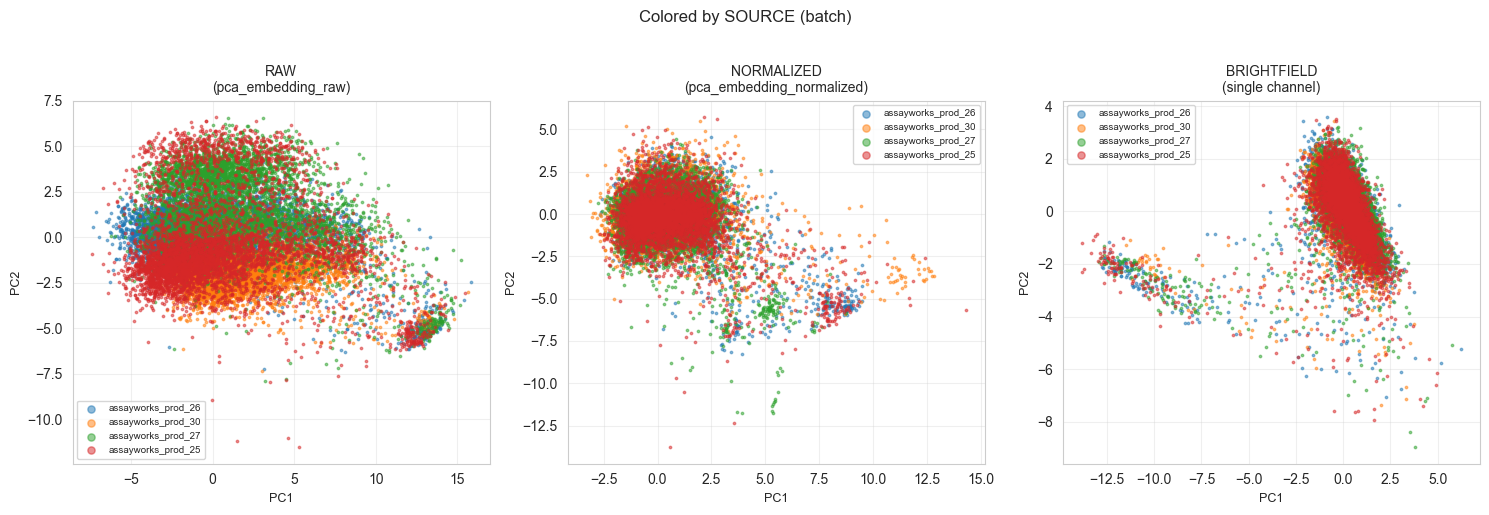

In [17]:
# SOURCE (batch effect)
compare_all_embeddings("source", "Colored by SOURCE (batch)", cmap="tab10")


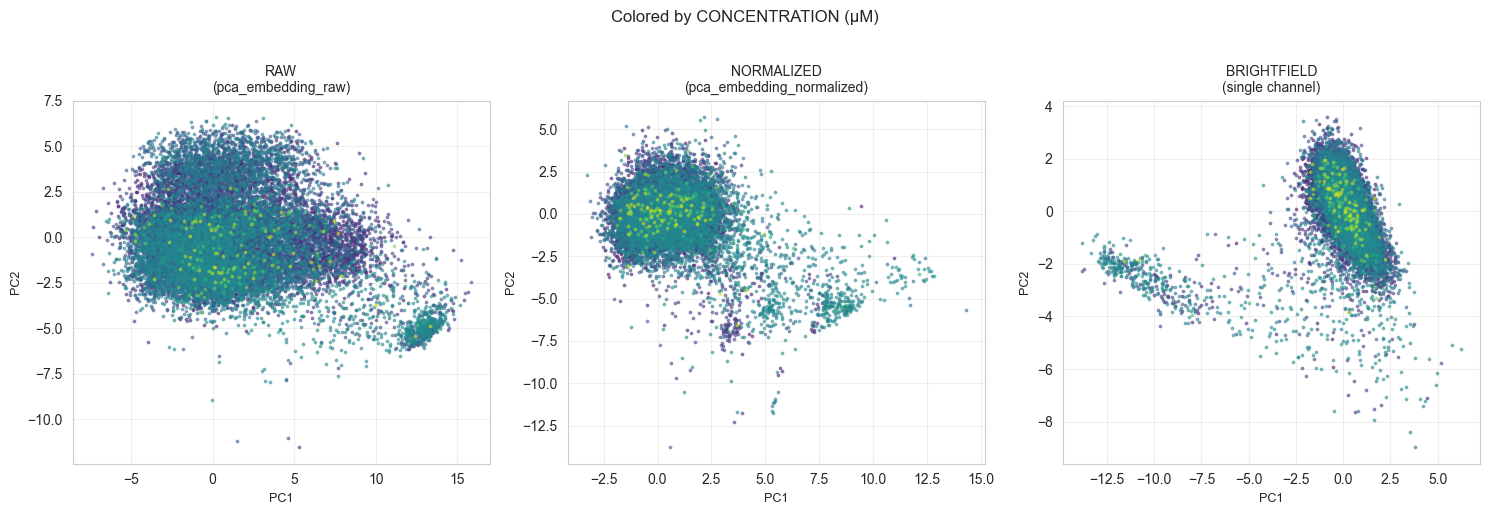

In [18]:
# CONCENTRATION (dose-response)
compare_all_embeddings("compound_concentration_um", "Colored by CONCENTRATION (µM)", cmap="viridis")


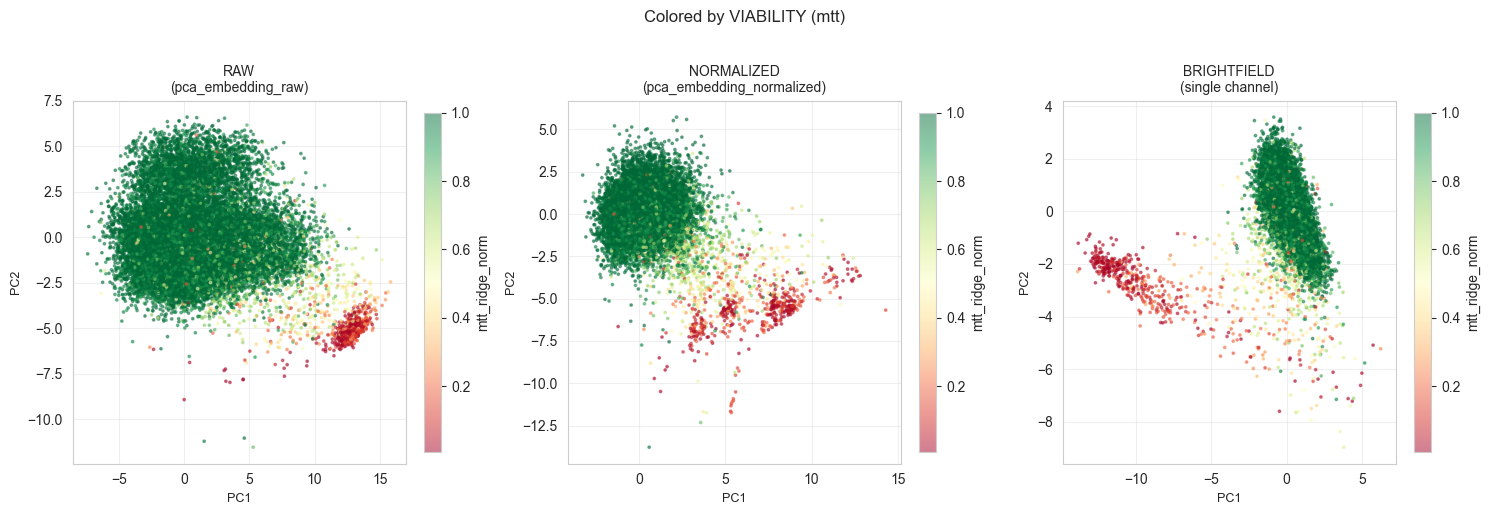

In [19]:
# VIABILITY (mtt_ridge_norm)
compare_all_embeddings("mtt_ridge_norm", "Colored by VIABILITY (mtt)", cmap="RdYlGn")


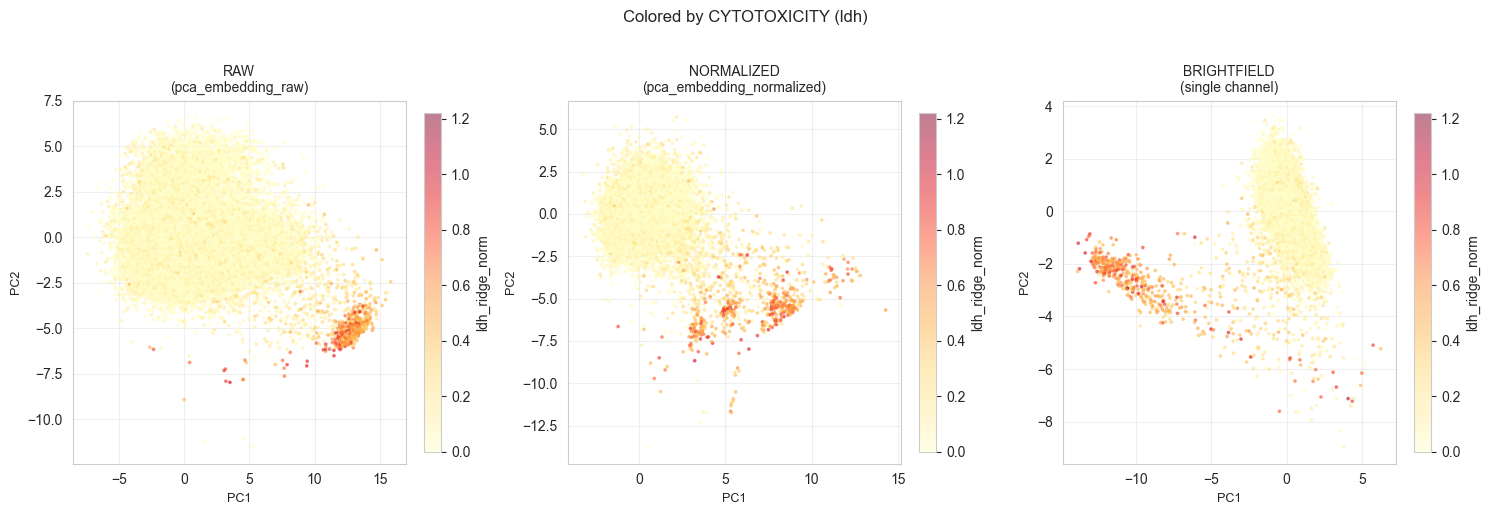

In [20]:
# CYTOTOXICITY (ldh_ridge_norm)
compare_all_embeddings("ldh_ridge_norm", "Colored by CYTOTOXICITY (ldh)", cmap="YlOrRd")


## Variance Decomposition

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

def variance_decomposition_sequential(embedding, df, factors_to_test, embedding_name):
    """
    Sequential variance decomposition: add factors one at a time, compute incremental R².
    This WILL sum to 100% (total R² + residual).
    """
    # Use first 50 PCs
    n_pcs = min(50, embedding.shape[1])
    X_pcs = embedding[:, :n_pcs]
    
    # Build design matrices for each factor
    factor_matrices = []
    factor_names = []
    valid_rows = np.ones(len(df), dtype=bool)
    
    for factor in factors_to_test:
        factor_vals = df[factor].values
        
        if pd.api.types.is_numeric_dtype(factor_vals):
            # Continuous
            valid = ~pd.isna(factor_vals)
            valid_rows &= valid
            vals = factor_vals.copy()
            vals[~valid] = np.nanmean(vals)
            vals = (vals - np.nanmean(vals)) / (np.nanstd(vals) + 1e-10)
            factor_matrices.append(vals.reshape(-1, 1))
            factor_names.append(factor)
        else:
            # Categorical: one-hot
            valid = pd.notna(df[factor])
            valid_rows &= valid
            le = LabelEncoder()
            encoded = le.fit_transform(df[factor].fillna("missing"))
            n_classes = len(le.classes_)
            onehot = np.zeros((len(encoded), n_classes - 1))
            for i, val in enumerate(encoded):
                if val > 0:
                    onehot[i, val - 1] = 1
            factor_matrices.append(onehot)
            factor_names.append(factor)
    
    # Use only complete cases
    X_pcs_valid = X_pcs[valid_rows]
    factor_matrices_valid = [fm[valid_rows] for fm in factor_matrices]
    
    # Total variance
    ss_tot = np.sum((X_pcs_valid - X_pcs_valid.mean(axis=0)) ** 2)
    
    # Sequential R²: add factors one at a time
    results = {}
    X_cumulative = np.empty((len(X_pcs_valid), 0))
    r2_prev = 0.0
    
    for factor, fm in zip(factor_names, factor_matrices_valid):
        # Add this factor to cumulative design matrix
        X_cumulative = np.hstack([X_cumulative, fm])
        
        # Fit model with factors added so far
        model = LinearRegression()
        model.fit(X_cumulative, X_pcs_valid)
        y_pred = model.predict(X_cumulative)
        
        ss_res = np.sum((X_pcs_valid - y_pred) ** 2)
        r2_current = 1 - (ss_res / ss_tot)
        
        # Incremental R² from adding this factor
        incremental_r2 = r2_current - r2_prev
        results[factor] = max(0, incremental_r2)
        
        r2_prev = r2_current
    
    # Residual = 1 - total R²
    results["Residual (unexplained)"] = 1 - r2_prev
    
    return results

# ══════════════════════════════════════════════════════════════════════════
# Compute for all 3 embeddings
# ══════════════════════════════════════════════════════════════════════════

factors = [
    "source",
    "plate", 
    "batch",
    "compound_id",
    "compound_concentration_um",
    "mtt_ridge_norm",
    "ldh_ridge_norm",
    "mean_nuclei_count",
]

print("Computing sequential variance decomposition...\n")

var_part_raw = variance_decomposition_sequential(pca_raw_bio, df_bio, factors, "raw")
var_part_norm = variance_decomposition_sequential(pca_norm_bio, df_bio, factors, "normalized")
var_part_bright = variance_decomposition_sequential(brightfield_bio, df_bio, factors, "brightfield")

print("✓ Done\n")


Computing sequential variance decomposition...

✓ Done



In [42]:
all_factors = factors + ["Residual (unexplained)"]

results_df = pd.DataFrame({
    "Factor": all_factors,
    "RAW (%)": [var_part_raw[f] * 100 for f in all_factors],
    "NORM (%)": [var_part_norm[f] * 100 for f in all_factors],
    "BRIGHT (%)": [var_part_bright[f] * 100 for f in all_factors],
})

print("="*80)
print("SEQUENTIAL VARIANCE DECOMPOSITION (Type I)")
print("="*80)
print(results_df.to_string(index=False))
print(f"\nSums (should be 100%): "
      f"RAW={results_df['RAW (%)'].sum():.1f}%  "
      f"NORM={results_df['NORM (%)'].sum():.1f}%  "
      f"BRIGHT={results_df['BRIGHT (%)'].sum():.1f}%")

SEQUENTIAL VARIANCE DECOMPOSITION (Type I)
                   Factor   RAW (%)  NORM (%)   BRIGHT (%)
                   source  4.203777  0.160107 1.865764e+00
                    plate 14.705156  5.892626 1.006575e+01
                    batch  0.000000  0.000000 1.110223e-14
              compound_id 22.055518 26.250216 2.035459e+01
compound_concentration_um  0.008735  0.007440 1.319772e-02
           mtt_ridge_norm 15.087046 18.366085 1.149468e+01
           ldh_ridge_norm  1.949122  3.022678 1.752652e+00
        mean_nuclei_count 10.088919  2.681950 9.152054e+00
   Residual (unexplained) 31.901726 43.618898 4.530131e+01

Sums (should be 100%): RAW=100.0%  NORM=100.0%  BRIGHT=100.0%


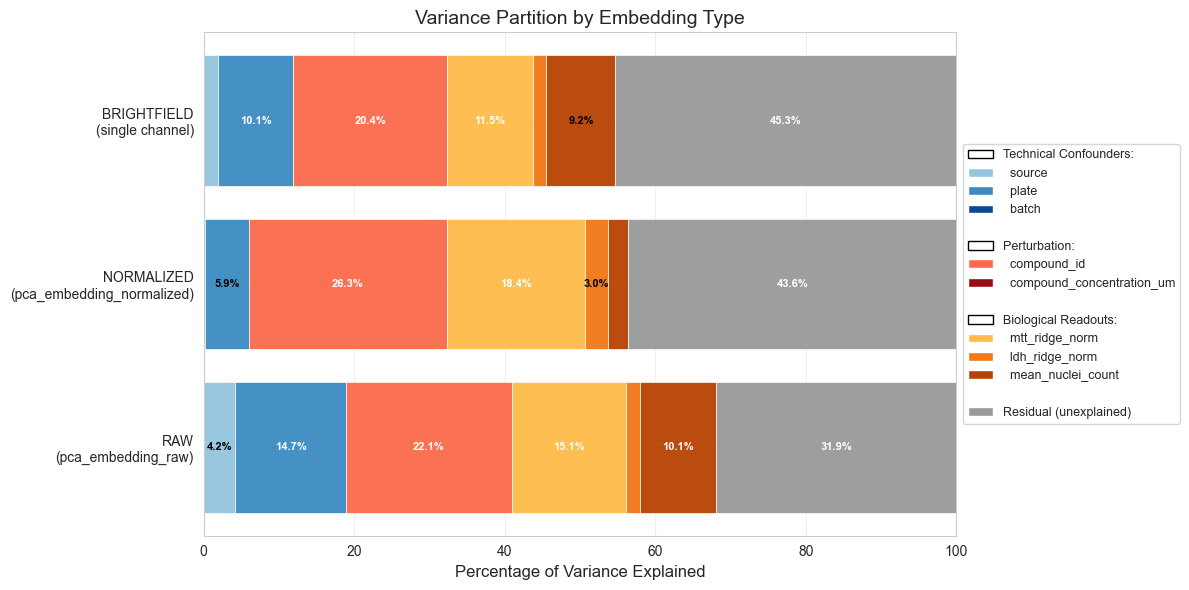

In [44]:
# HORIZONTAL STACKED BARS with categorical color scheme

fig, ax = plt.subplots(figsize=(12, 6))

embeddings = ["RAW\n(pca_embedding_raw)", 
              "NORMALIZED\n(pca_embedding_normalized)", 
              "BRIGHTFIELD\n(single channel)"]
y = np.arange(len(embeddings))

# Define factor categories and color palettes
factor_categories = {
    # Technical confounders - blues
    "source": ("Technical", 0),
    "plate": ("Technical", 1),
    "batch": ("Technical", 2),
    
    # Perturbation - reds
    "compound_id": ("Perturbation", 0),
    "compound_concentration_um": ("Perturbation", 1),
    
    # Biological readouts - yellows/oranges
    "mtt_ridge_norm": ("Biological", 0),
    "ldh_ridge_norm": ("Biological", 1),
    "mean_nuclei_count": ("Biological", 2),
    
    # Residual - gray
    "Residual (unexplained)": ("Residual", 0),
}

# Generate colors
blues = plt.cm.Blues(np.linspace(0.4, 0.9, 3))  # darker to lighter blue
reds = plt.cm.Reds(np.linspace(0.5, 0.9, 2))    # darker to lighter red
yellows = plt.cm.YlOrBr(np.linspace(0.4, 0.8, 3))  # yellow-orange range
gray = np.array([[0.6, 0.6, 0.6, 1.0]])

color_map = {}
for factor, (category, idx) in factor_categories.items():
    if category == "Technical":
        color_map[factor] = blues[idx]
    elif category == "Perturbation":
        color_map[factor] = reds[idx]
    elif category == "Biological":
        color_map[factor] = yellows[idx]
    else:  # Residual
        color_map[factor] = gray[0]

# Plot stacked bars
left = np.zeros(len(embeddings))
for factor in all_factors:
    values = np.array([
        var_part_raw[factor],
        var_part_norm[factor],
        var_part_bright[factor]
    ]) * 100  # convert to percentage
    
    bars = ax.barh(y, values, left=left, label=factor, 
                   color=color_map[factor], alpha=0.95, edgecolor='white', linewidth=0.5)
    
    # Add text labels for values >3%
    for j, (val, l) in enumerate(zip(values, left)):
        if val > 3:
            ax.text(l + val/2, j, f"{val:.1f}%", 
                   ha='center', va='center', fontsize=8, fontweight='bold',
                   color='white' if val > 10 else 'black')
    
    left += values

ax.set_xlabel('Percentage of Variance Explained', fontsize=12)
ax.set_title('Variance Partition by Embedding Type', fontsize=14)
ax.set_yticks(y)
ax.set_yticklabels(embeddings, fontsize=10)
ax.set_xlim([0, 100])

# Custom legend with category headers
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='white', edgecolor='black', label='Technical Confounders:'),
    Patch(facecolor=blues[0], label='  source'),
    Patch(facecolor=blues[1], label='  plate'),
    Patch(facecolor=blues[2], label='  batch'),
    Patch(facecolor='white', edgecolor='white', label=''),  # spacer
    Patch(facecolor='white', edgecolor='black', label='Perturbation:'),
    Patch(facecolor=reds[0], label='  compound_id'),
    Patch(facecolor=reds[1], label='  compound_concentration_um'),
    Patch(facecolor='white', edgecolor='white', label=''),  # spacer
    Patch(facecolor='white', edgecolor='black', label='Biological Readouts:'),
    Patch(facecolor=yellows[0], label='  mtt_ridge_norm'),
    Patch(facecolor=yellows[1], label='  ldh_ridge_norm'),
    Patch(facecolor=yellows[2], label='  mean_nuclei_count'),
    Patch(facecolor='white', edgecolor='white', label=''),  # spacer
    Patch(facecolor=gray[0], label='Residual (unexplained)'),
]

ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), 
          fontsize=9, frameon=True)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### Observations:
* Batch correction works: 
    * Normalization reduced technical variance from 18.9% → 5.9%
    * Biological signal (compound_id) was preserved (22.1% → 26.3%)
* Viability/toxicity (mtt + ldh) explains ~25-29% of variance across all embeddings. This is a potential issue for MoA prediction - models might only learn "toxic vs non-toxic" rather than specific mechanisms 
* Brightfield has less batch effect (10.1% vs 18.9% raw) but also captures less biological signal (20.4% vs 22.1% compound_id)


## 5  UMAP nonlinear projection

PCA is linear. For prettier visualizations that capture nonlinear structure, compute UMAP on `pca_norm_bio`.

**Note:** This is purely for visualization. The ML models (Section 6) will use the full 128-dim embeddings.


In [45]:
# Compute nonlinear 2D projection for visualization

print("Computing UMAP (n_neighbors=30, min_dist=0.3)...")
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=30, min_dist=0.3)
coords_2d = reducer.fit_transform(pca_norm_bio)
method = "UMAP"

df_bio["nl_dim0"] = coords_2d[:, 0]
df_bio["nl_dim1"] = coords_2d[:, 1]
print(f"✓ {method} coordinates computed")


Computing UMAP (n_neighbors=30, min_dist=0.3)...


/opt/anaconda3/envs/cell_painting/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✓ UMAP coordinates computed


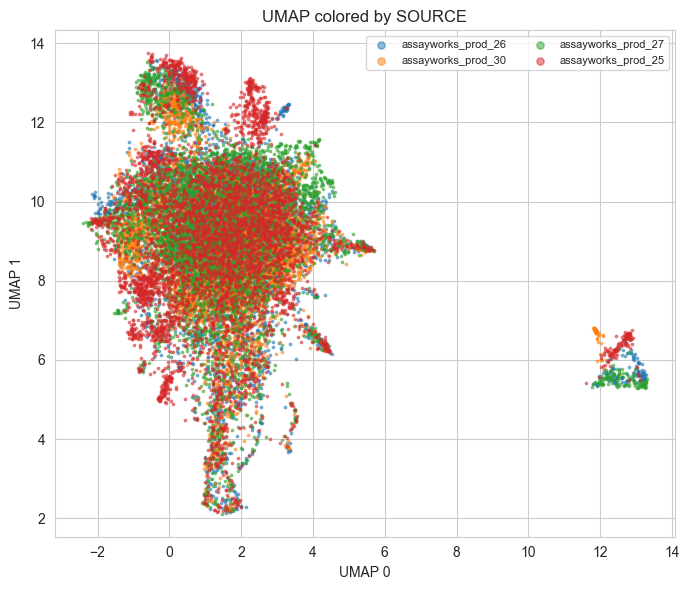

In [47]:
def scatter_nonlinear(col, title, cmap="viridis", s=3, alpha=0.5):
    """Scatter plot of nonlinear 2D projection colored by metadata."""
    fig, ax = plt.subplots(figsize=(7, 6))
    vals = df_bio[col]
    
    is_categorical = (not pd.api.types.is_numeric_dtype(vals)) or (vals.nunique() <= 25)
    
    if is_categorical:
        unique_vals = vals.unique()
        palette = sns.color_palette(cmap, n_colors=min(len(unique_vals), 20))
        for i, val in enumerate(unique_vals[:20]):
            mask = vals == val
            ax.scatter(df_bio.loc[mask, "nl_dim0"], df_bio.loc[mask, "nl_dim1"],
                       s=s, alpha=alpha, label=str(val), color=palette[i % len(palette)])
        if len(unique_vals) <= 10:
            ax.legend(fontsize=8, markerscale=3, loc="best", ncol=2)
    else:
        sc = ax.scatter(df_bio["nl_dim0"], df_bio["nl_dim1"],
                        c=vals, cmap=cmap, s=s, alpha=alpha)
        plt.colorbar(sc, ax=ax, label=col)
    
    ax.set_xlabel(f"{method} 0", fontsize=10)
    ax.set_ylabel(f"{method} 1", fontsize=10)
    ax.set_title(title, fontsize=12)
    plt.tight_layout()
    plt.show()

# Visualize by key metadata
scatter_nonlinear("source", f"{method} colored by SOURCE", cmap="tab10")


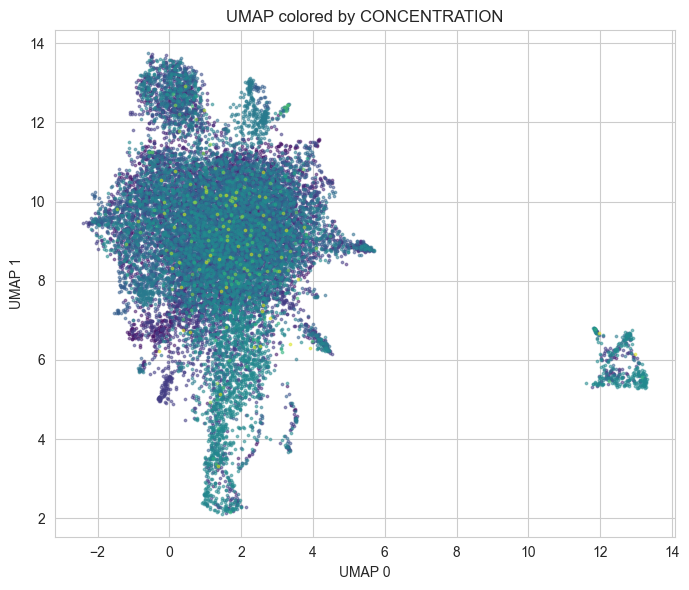

In [48]:
scatter_nonlinear('compound_concentration_um', f'{method} colored by CONCENTRATION')

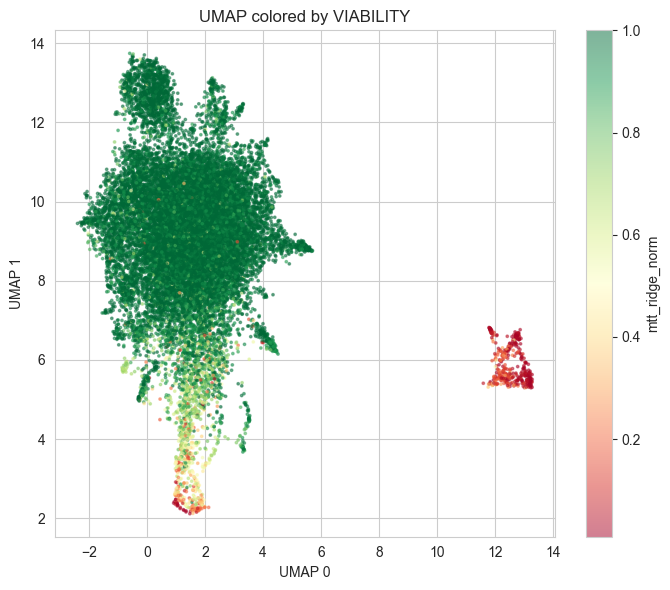

In [49]:
scatter_nonlinear('mtt_ridge_norm', f'{method} colored by VIABILITY', cmap='RdYlGn')

### (Optional) Highlight known MoA classes

Check if compounds with the same mechanism cluster together.


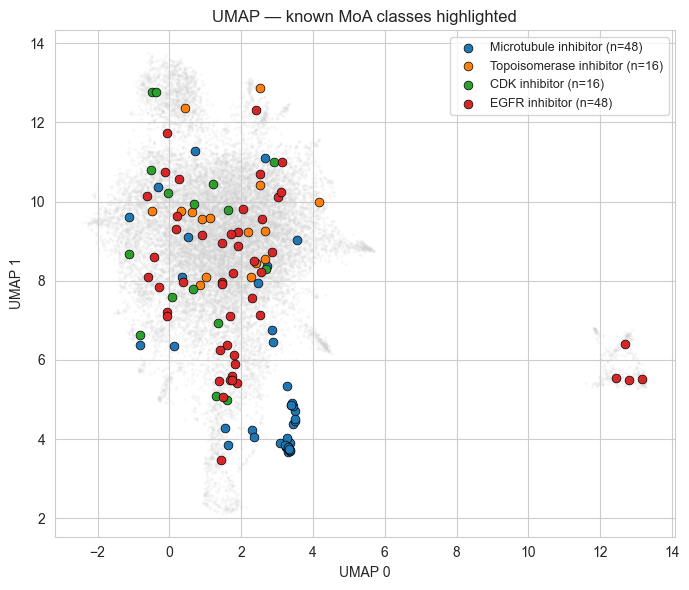

In [51]:
MOA_EXAMPLES = {
    "Microtubule inhibitor": ["Vinblastine", "Vincristine", "Nocodazole", "Paclitaxel", "Colchicine"],
    "Topoisomerase inhibitor": ["Etoposide", "Doxorubicin", "Camptothecin", "Topotecan"],
    "CDK inhibitor": ["Flavopiridol", "Roscovitine", "Dinaciclib", "Palbociclib"],
    "EGFR inhibitor": ["Erlotinib", "Gefitinib", "Lapatinib"],
}

fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(df_bio["nl_dim0"], df_bio["nl_dim1"], s=2, alpha=0.1, color="lightgrey")

palette = sns.color_palette("tab10", len(MOA_EXAMPLES))
for color, (moa, names) in zip(palette, MOA_EXAMPLES.items()):
    mask = df_bio["compound_id"].isin(names)
    n = mask.sum()
    if n > 0:
        ax.scatter(df_bio.loc[mask, "nl_dim0"], df_bio.loc[mask, "nl_dim1"],
                   s=40, c=[color], edgecolors="k", linewidths=0.5,
                   label=f"{moa} (n={n})", zorder=3)

ax.legend(fontsize=9)
ax.set_title(f"{method} — known MoA classes highlighted")
ax.set_xlabel(f"{method} 0"); ax.set_ylabel(f"{method} 1")
plt.tight_layout(); plt.show()


## 6  Multi-label target prediction — Multi-model comparison

**Task:** Predict `compound_target` from embeddings vs. baseline scalar features.

**Models:** Logistic Regression, Random Forest, XGBoost, Ensemble (soft voting)

**Metrics:** F1, Precision, Recall, Specificity, AUC

**Feature sets:**
- **Baseline X**: scalar assay/image features (mtt, ldh, nuclei count, etc.)
- **Embedding X**: `pca_embedding_normalized` (128-dim, full embeddings — not just 2D)


In [52]:
def parse_multilabel(series, sep="; "):
    return (
        series.dropna()
        .str.split(sep)
        .apply(lambda x: [s.strip() for s in x if s.strip()])
    )

# ── Build target label matrix (MIN_SAMPLES threshold) ──
MIN_SAMPLES = 30

target_lists = parse_multilabel(df_bio["compound_target"])
valid_target = target_lists.notna()
target_lists_valid = target_lists[valid_target]

all_targets = Counter()
for tlist in target_lists_valid:
    all_targets.update(tlist)

selected_targets = [t for t, count in all_targets.items() if count >= MIN_SAMPLES]
selected_targets.sort()

print(f"Total unique targets: {len(all_targets)}")
print(f"Targets with ≥{MIN_SAMPLES} examples: {len(selected_targets)}")
print(f"Coverage: {sum(all_targets[t] for t in selected_targets) / sum(all_targets.values()):.1%}")

mlb_target = MultiLabelBinarizer(classes=selected_targets)
y_target = mlb_target.fit_transform(target_lists_valid)

print(f"\nLabel matrix shape: {y_target.shape}")
print(f"Avg labels/sample: {y_target.sum(axis=1).mean():.2f}")


Total unique targets: 254
Targets with ≥30 examples: 176
Coverage: 96.3%

Label matrix shape: (16720, 176)
Avg labels/sample: 1.97


/opt/anaconda3/envs/cell_painting/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['ADC Linker', 'ATP Citrate Lyase', 'Acetyl-CoA Carboxylase', 'Adenylate Cyclase', 'Aldehyde Dehydrogenase (ALDH)', 'Aldose Reductase', 'Aminopeptidase', 'Aurora Kinase', 'BCRP', 'Beclin1', 'Beta-secretase', 'Bradykinin Receptor', 'CETP', 'CRFR', 'CRM1', 'CXCR', 'CaSR', 'Casein Kinase', 'Cholecystokinin Receptor', 'Cuproptosis', 'Deubiquitinase', 'Dihydroorotate Dehydrogenase', 'Dopamine β-hydroxylase', 'E1/E2/E3 Enzyme', 'EBV', 'Elastase', 'Epigenetic Reader Domain', 'Epoxide Hydrolase', 'FXR', 'Farnesyl Transferase', 'Fatty Acid Synthase (FASN)', 'Filovirus', 'GCGR', 'GPR109A', 'GSK-3', 'Glucosylceramide Synthase (GCS)', 'HCV Protease', 'HPV', 'IGF-1R', 'IRE1', 'Imidazoline Receptor', 'Insulin Receptor', 'Lactate Dehydrogenase', 'Ligands for Target Protein for PROTAC', 'Lipoxygenase', 'MDM-2/p53', 'Microsomal Triglyceride Transfer Protein (MTP)', 'Mucin',

In [53]:
# ── Prepare X matrices ──

# Embedding X: use FULL 128-dim pca_norm (not just 2D projection)
X_emb_target = pca_norm_bio[valid_target.values]
print(f"Embedding X shape: {X_emb_target.shape}")

# Baseline X: scalar features
SCALAR_FEATURES = [
    c for c in df.columns
    if c not in ["library", "source", "plate", "well_id", "compound_id",
                 "compound_concentration_um", "compound_biological_activity",
                 "compound_target", "compound_pathway",
                 "brightfield", "pca_embedding_raw", "pca_embedding_normalized"]
]

X_scalar_all = df_bio[SCALAR_FEATURES].apply(pd.to_numeric, errors="coerce")
X_scalar_all = X_scalar_all.fillna(X_scalar_all.median())
X_scalar_target = X_scalar_all.values[valid_target.values]

print(f"Baseline X shape: {X_scalar_target.shape}")


IndexError: boolean index did not match indexed array along axis 0; size of axis is 20160 but size of corresponding boolean axis is 16720

In [54]:
def eval_multilabel_multimodel(X, y, label_names, n_splits=5, verbose=True):
    """Multi-model multi-label classification with comprehensive metrics."""
    
    base_models = {
        "Logistic Regression": LogisticRegression(C=1.0, max_iter=1000, solver='lbfgs', random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=5,
                                                 random_state=42, n_jobs=-1),
    }
    
    if HAS_XGB:
        base_models["XGBoost"] = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                                                random_state=42, n_jobs=-1, eval_metric='logloss')
    
    models = {name: OneVsRestClassifier(clf, n_jobs=-1 if name == "Logistic Regression" else 1)
              for name, clf in base_models.items()}
    
    if len(base_models) >= 2:
        ensemble_base = VotingClassifier(
            estimators=[(name, clf) for name, clf in base_models.items()],
            voting='soft', n_jobs=-1
        )
        models["Ensemble"] = OneVsRestClassifier(ensemble_base, n_jobs=1)
    
    # Filter labels with insufficient positives
    min_pos = n_splits
    keep = np.array([y[:, i].sum() >= min_pos for i in range(y.shape[1])])
    y_k = y[:, keep]
    names_k = [n for n, k in zip(label_names, keep) if k]
    
    if verbose:
        print(f"Kept {keep.sum()} / {len(label_names)} labels for CV")
    
    primary = y_k[:, y_k.sum(axis=0).argmax()]
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    results = {name: {
        'macro_f1': [], 'micro_f1': [], 'macro_precision': [],
        'macro_recall': [], 'macro_specificity': [], 'macro_auc': [],
        'per_label_f1': {n: [] for n in names_k},
    } for name in models}
    
    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, primary)):
        if verbose:
            print(f"  Fold {fold_idx+1}/{n_splits}...", end=" ")
        
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y_k[train_idx], y_k[test_idx]
        
        for model_name, clf in models.items():
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            
            try:
                y_prob = clf.predict_proba(X_test)
            except AttributeError:
                y_prob = None
            
            results[model_name]['macro_f1'].append(f1_score(y_test, y_pred, average='macro', zero_division=0))
            results[model_name]['micro_f1'].append(f1_score(y_test, y_pred, average='micro', zero_division=0))
            results[model_name]['macro_precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
            results[model_name]['macro_recall'].append(recall_score(y_test, y_pred, average='macro', zero_division=0))
            
            specificities = []
            for i in range(y_test.shape[1]):
                tn = ((y_test[:, i] == 0) & (y_pred[:, i] == 0)).sum()
                fp = ((y_test[:, i] == 0) & (y_pred[:, i] == 1)).sum()
                spec = tn / (tn + fp) if (tn + fp) > 0 else 0
                specificities.append(spec)
            results[model_name]['macro_specificity'].append(np.mean(specificities))
            
            if y_prob is not None:
                try:
                    auc = roc_auc_score(y_test, y_prob, average='macro')
                    results[model_name]['macro_auc'].append(auc)
                except ValueError:
                    results[model_name]['macro_auc'].append(np.nan)
            else:
                results[model_name]['macro_auc'].append(np.nan)
            
            for i, label in enumerate(names_k):
                f1 = f1_score(y_test[:, i], y_pred[:, i], average='binary', zero_division=0)
                results[model_name]['per_label_f1'][label].append(f1)
        
        if verbose:
            print("✓")
    
    summary = {}
    for model_name, res in results.items():
        summary[model_name] = {
            'macro_f1_mean': np.mean(res['macro_f1']),
            'macro_f1_std': np.std(res['macro_f1']),
            'micro_f1_mean': np.mean(res['micro_f1']),
            'macro_precision_mean': np.mean(res['macro_precision']),
            'macro_recall_mean': np.mean(res['macro_recall']),
            'macro_specificity_mean': np.mean(res['macro_specificity']),
            'macro_auc_mean': np.nanmean(res['macro_auc']),
            'per_label_f1': {n: (np.mean(v), np.std(v)) for n, v in res['per_label_f1'].items()},
        }
    
    return summary, names_k

print("✓ Evaluation function defined")


✓ Evaluation function defined


In [55]:
print("="*80)
print("EVALUATING BASELINE (scalar features)")
print("="*80)
res_baseline, labels_kept = eval_multilabel_multimodel(
    X_scalar_target, y_target, selected_targets, n_splits=5
)

print("\n" + "="*80)
print("BASELINE SUMMARY")
print("="*80)
for model_name, m in res_baseline.items():
    print(f"{model_name:20s}: F1={m['macro_f1_mean']:.3f}±{m['macro_f1_std']:.3f}  "
          f"Prec={m['macro_precision_mean']:.3f}  Rec={m['macro_recall_mean']:.3f}  "
          f"Spec={m['macro_specificity_mean']:.3f}  AUC={m['macro_auc_mean']:.3f}")


EVALUATING BASELINE (scalar features)


NameError: name 'X_scalar_target' is not defined

In [ ]:
print("="*80)
print("EVALUATING EMBEDDINGS (pca_embedding_normalized)")
print("="*80)
res_emb, _ = eval_multilabel_multimodel(
    X_emb_target, y_target, selected_targets, n_splits=5
)

print("\n" + "="*80)
print("EMBEDDING SUMMARY")
print("="*80)
for model_name, m in res_emb.items():
    print(f"{model_name:20s}: F1={m['macro_f1_mean']:.3f}±{m['macro_f1_std']:.3f}  "
          f"Prec={m['macro_precision_mean']:.3f}  Rec={m['macro_recall_mean']:.3f}  "
          f"Spec={m['macro_specificity_mean']:.3f}  AUC={m['macro_auc_mean']:.3f}")


In [ ]:
# ── Visualize: Baseline vs Embedding comparison ──

model_names = list(res_baseline.keys())
metrics_to_plot = ['macro_f1_mean', 'macro_precision_mean', 'macro_recall_mean',
                   'macro_specificity_mean', 'macro_auc_mean']
metric_labels = ['Macro F1', 'Precision', 'Recall', 'Specificity', 'AUC']

fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(18, 5))

for ax, metric, label in zip(axes, metrics_to_plot, metric_labels):
    x = np.arange(len(model_names))
    w = 0.35
    
    baseline_vals = [res_baseline[m][metric] for m in model_names]
    emb_vals = [res_emb[m][metric] for m in model_names]
    
    ax.bar(x - w/2, baseline_vals, w, label='Baseline', color='coral', alpha=0.8)
    ax.bar(x + w/2, emb_vals, w, label='Embedding', color='steelblue', alpha=0.8)
    
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel(label)
    ax.set_ylim([0, 1])
    ax.legend(fontsize=8)
    ax.set_title(label)
    ax.grid(axis='y', alpha=0.3)

plt.suptitle("Target Prediction: Baseline vs Embedding", y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
# ── Best/worst predicted targets ──

best_emb_model = max(res_emb.items(), key=lambda x: x[1]['macro_f1_mean'])[0]
print(f"Best embedding model: {best_emb_model}\n")

per_label_f1 = res_emb[best_emb_model]['per_label_f1']
label_f1_pairs = [(label, f1_mean) for label, (f1_mean, _) in per_label_f1.items()]
label_f1_pairs.sort(key=lambda x: x[1], reverse=True)

print("TOP 10 EASIEST TARGETS TO PREDICT")
print("="*60)
for label, f1 in label_f1_pairs[:10]:
    print(f"{label:45s}  F1={f1:.3f}  (n={all_targets[label]:4d})")

print("\nTOP 10 HARDEST TARGETS TO PREDICT")
print("="*60)
for label, f1 in label_f1_pairs[-10:]:
    print(f"{label:45s}  F1={f1:.3f}  (n={all_targets[label]:4d})")


## 7  Pathway prediction

Same multi-model analysis for `compound_pathway`.

In [ ]:
pathway_lists = parse_multilabel(df_bio["compound_pathway"])
valid_pathway = pathway_lists.notna()
pathway_lists_valid = pathway_lists[valid_pathway]

all_pathways = Counter()
for plist in pathway_lists_valid:
    all_pathways.update(plist)

selected_pathways = [p for p, count in all_pathways.items() if count >= MIN_SAMPLES]
selected_pathways.sort()

print(f"Pathways with ≥{MIN_SAMPLES} examples: {len(selected_pathways)}")

mlb_pathway = MultiLabelBinarizer(classes=selected_pathways)
y_pathway = mlb_pathway.fit_transform(pathway_lists_valid)

X_emb_pathway = pca_norm_bio[valid_pathway.values]
X_scalar_pathway = X_scalar_all.values[valid_pathway.values]

print(f"Label matrix shape: {y_pathway.shape}")


In [ ]:
print("Evaluating PATHWAYS - Baseline...")
res_base_pw, _ = eval_multilabel_multimodel(X_scalar_pathway, y_pathway, selected_pathways, n_splits=5)

print("\nEvaluating PATHWAYS - Embedding...")
res_emb_pw, _ = eval_multilabel_multimodel(X_emb_pathway, y_pathway, selected_pathways, n_splits=5)

print("\n" + "="*80)
print("PATHWAY RESULTS")
print("="*80)
best_base_pw = max(res_base_pw.items(), key=lambda x: x[1]['macro_f1_mean'])[0]
best_emb_pw = max(res_emb_pw.items(), key=lambda x: x[1]['macro_f1_mean'])[0]
print(f"Best baseline: {best_base_pw} (F1={res_base_pw[best_base_pw]['macro_f1_mean']:.3f})")
print(f"Best embedding: {best_emb_pw} (F1={res_emb_pw[best_emb_pw]['macro_f1_mean']:.3f})")


## 8  Summary

**Key findings to document:**

1. **Batch correction assessment** (Section 4):
   - Does normalized embedding remove source clustering?
   - Is biological signal (MoA) preserved?

2. **Model performance** (Section 6):
   - Best baseline model: _____
   - Best embedding model: _____
   - Embedding F1 vs baseline F1: _____

3. **Which targets/pathways are predictable?**
   - High F1 (>0.7): _____
   - Low F1 (<0.3): _____
   - Why? Sample size? Subtle phenotype?

4. **Next steps:**
   - **Notebook 03**: Formalize batch effect quantification
   - **Notebook 04**: Try alternative normalizations to beat `pca_embedding_normalized`
